In [1]:
import pandas as pd
import pypsa

In [51]:
# Load PyPSA network.
n = pypsa.Network("./base_s_90_elec_lc1.0_Co2L0.01.nc")

INFO:pypsa.io:Imported network base_s_90_elec_lc1.0_Co2L0.01.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


/home/algro/miniforge3/envs/notebook_analysis/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x7ffe8f5b95e0>,
 <matplotlib.collections.LineCollection at 0x7ffe8c077ec0>)

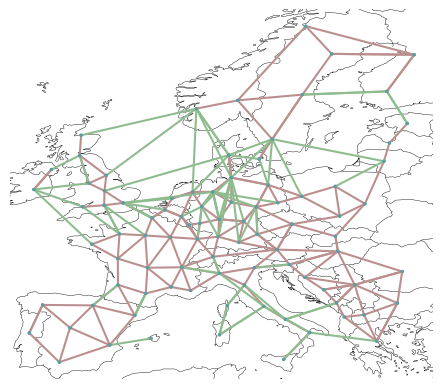

In [52]:
# Map overview of the network (for reference).
n.plot()

In [53]:
# Overview of the networks: buses correspond to nodes, this is a network with 90 nodes across all of Europe.
n.buses[n.buses.carrier == "AC"] # all nodes.

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country,substation_off,location,substation_lv
Bus,,,,,,,,,,,,,,,,
AL0 0,380.0,,19.845910,41.511340,AC,,1.0,0.0,inf,PQ,,,AL,1.0,,1.0
AT0 0,380.0,,13.874983,47.488807,AC,,1.0,0.0,inf,Slack,AT0 0 CCGT,,AT,1.0,,1.0
BA0 0,380.0,,18.001468,43.935339,AC,,1.0,0.0,inf,PQ,,,BA,1.0,,1.0
BE0 0,380.0,,5.386936,50.419036,AC,,1.0,0.0,inf,PQ,,,BE,1.0,,1.0
BE0 1,380.0,,3.923387,51.020553,AC,,1.0,0.0,inf,PQ,,,BE,1.0,,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE1 0,380.0,,13.450366,57.284545,AC,,1.0,0.0,inf,PQ,,,SE,1.0,,1.0
SE1 1,380.0,,16.132706,61.241326,AC,,1.0,0.0,inf,PQ,,,SE,1.0,,1.0
SE1 2,380.0,,18.731434,64.858085,AC,,1.0,0.0,inf,PQ,,,SE,1.0,,1.0


In [55]:
# Save all nodes with coordinates.
n.buses[n.buses.carrier == "AC"][["x", "y"]].to_csv("./nodes.csv")

In [56]:
# Prepare cost dataframe.
costs = pd.DataFrame(columns = ["capital_cost", "unit"]).astype(float)

In [57]:
# Save all lines including capacities (s_nom), both nodes (bus0, bus1), and the line length and capital cost.
n.lines[n.lines.carrier == "AC"][["s_nom", "bus0", "bus1", "length", "capital_cost"]].to_csv("./lines.csv")
# Compute capital cost per MWkm.
costs.loc["AC_line", "capital_cost"] = n.lines.loc["0", "capital_cost"] / n.lines.loc["0", "length"]
costs.loc["AC_line", "unit"] = "EUR/MWkm"

/tmp/ipykernel_20321/104365233.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'EUR/MWkm' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  costs.loc["AC_line", "unit"] = "EUR/MWkm"


In [58]:
# Save all links including capacities (p_nom), both nodes (bus0, bus1), and the capital cost.
n.links[n.links.carrier == "DC"][["p_nom", "bus0", "bus1", "length", "capital_cost"]].to_csv("./links.csv")
# Compute capital cost per MW.
costs.loc["DC_link", "capital_cost"] = n.links.loc["relation/5487095", "capital_cost"] / n.links.loc["relation/5487095", "length"]
costs.loc["DC_link", "unit"] = "EUR/MWkm"


In [61]:
# Save all capacity factors (hourly) for solar and wind generators.
solar_generators = n.generators[n.generators.carrier.str.contains("solar")].index
wind_generators = n.generators[n.generators.carrier.str.contains("wind")].index
ror_generators = n.generators[n.generators.carrier.str.contains("ror")].index

# Solar CF.
solar_cf = n.generators_t.p_max_pu.loc[:, solar_generators].round(3)
solar_cf.to_csv("./solar_cf.csv")
# Wind CF.
wind_cf = n.generators_t.p_max_pu.loc[:, wind_generators].round(3)
wind_cf.to_csv("./wind_cf.csv")
# ROR CF.
ror_cf = n.generators_t.p_max_pu.loc[:, ror_generators].round(3)
ror_cf.to_csv("./ror_cf.csv")

# Capex for solar, wind.
costs.loc["solar", "capital_cost"] = n.generators.loc["SK0 0 solar", "capital_cost"] 
costs.loc["solar", "unit"] = "EUR/MW"
costs.loc["solar-hsat", "capital_cost"] = n.generators.loc["SK0 0 solar-hsat", "capital_cost"]
costs.loc["solar-hsat", "unit"] = "EUR/MW"
costs.loc["onwind", "capital_cost"] = n.generators.loc["SK0 0 onwind", "capital_cost"]
costs.loc["onwind", "unit"] = "EUR/MW"

# Capital costs for onshore wind are dependent on the node, so saved separately.
offwind_costs = n.generators[n.generators.carrier.str.contains("offwind")]["capital_cost"].round(0)


In [63]:
# Save load per node.
n.loads_t.p_set.round(0).to_csv("./load.csv")

In [64]:
# Save hydropower plants
n.generators[n.generators.carrier == "ror"][["bus", "p_nom"]].to_csv("./ror_plants.csv")
n.storage_units[n.storage_units.carrier == "PHS"][["bus", "p_nom"]].to_csv("./phs_plants.csv")
n.storage_units[n.storage_units.carrier == "hydro"][["bus", "p_nom"]].to_csv("./hydro_plants.csv")

# Hydropower inflow. (hourly)
n.storage_units_t.inflow.round(0).to_csv("./inflow.csv")

In [68]:
# Existing gas capacity, bus, marginal cost, capital cost (for OCGT and CCGT).
n.generators[n.generators.carrier.str.contains("GT")][["bus", "p_nom", "marginal_cost", "capital_cost"]].to_csv("gas.csv")